1. Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

2. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)


3. Вывести сравнение полученных моделей по метрикам бизнеса по показателям с урока
- стоимость лечения 15000р, если сделали тест и начали лечить вовремя
- стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
- стоимость теста 1400р

4. Сделать выводы о том, какая модель справилась с задачей лучше других

Выполним задания 1-4 в виде единого решения для каждой обучаемой модели

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
!wget 'https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G' -O train_case2.csv

--2023-04-25 00:20:07--  https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G
Распознаётся drive.google.com (drive.google.com)… 64.233.165.194, 2a00:1450:4010:c1e::c2
Подключение к drive.google.com (drive.google.com)|64.233.165.194|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 303 See Other
Адрес: https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fretbaq6coe66j8qdcu6c7v75rd7n01o/1682371200000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download&uuid=11d33105-9b8f-4c73-bd9e-46e229051e9a [переход]
Предупреждение: в HTTP маски не поддерживаются.
--2023-04-25 00:20:10--  https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fretbaq6coe66j8qdcu6c7v75rd7n01o/1682371200000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download&uuid=11d33105-9b8f-4c73-bd9e-46e229051e9a
Распознаётся doc-00-c0-docs.googleusercontent.com (doc-00-c0-docs.

In [3]:
df = pd.read_csv('train_case2.csv', sep=';')
df.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [5]:
# разделим данные на train/test
feature = df.drop(columns='cardio')
target = df['cardio']
X_train, X_test, y_train, y_test = train_test_split(feature, target, random_state=42)

In [6]:
from sklearn.preprocessing import StandardScaler

# непрерывные признаки
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

# категориальные признаки
cat_cols = ['gender', 'cholesterol']

# булевы признаки
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [7]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[ 0.09144178,  0.44594423,  0.05752649, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.46216539,  0.20194394, -0.84752919, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.5702846 , -1.01805752,  1.79801819, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.67238553,  0.56794437, -0.01209318, ...,  0.        ,
         0.        ,  1.        ],
       [-0.50009534,  0.32394408, -0.29057185, ...,  0.        ,
         0.        ,  0.        ],
       [-1.76136594,  1.54394554, -0.70828985, ...,  0.        ,
         0.        ,  1.        ]])

#### Обучение логистической регрессии

In [8]:
model_lr = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=42)),
])

# обучим пайплайн на всем тренировочном датасете
model_lr.fit(X_train, y_train)

# предсказанные вероятности принадлежности классу 1
preds = model_lr.predict_proba(X_test)[:, 1]

# данные pr-кривой
precision, recall, thresholds = precision_recall_curve(y_test, preds)

# f1-мера
fscore = (2 * precision * recall) / (precision + recall)

# находим индекс максимальной f1-меры
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.39710921543608974, F-Score=0.735, Precision=0.656, Recall=0.837


In [9]:
# находим интегральную меру как площадь roc-кривой
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.7852393986644697

In [10]:
rubl_test = 1400
rubl_early_treatment = 15000
rubl_late_treatment = 20000

In [11]:
cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать МЛ:', rubl_ML)

расходы, если использовать МЛ: 155104800


In [12]:
metrics_df = pd.DataFrame(columns=['model', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC', 'rubl_ML'])
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML


In [13]:
metrics_df = metrics_df.append({
    'model': type(model_lr['classifier']).__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc,
    'rubl_ML': rubl_ML
}, ignore_index=True)

metrics_df

/tmp/ipykernel_107950/2895625164.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML
0,LogisticRegression,0.397109,0.735426,0.655534,0.837494,0.785239,155104800


#### Модель градиентного бустинга

In [14]:
from sklearn.ensemble import GradientBoostingClassifier


model_gb = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state=42)), # гиперпараметры по умолчанию
])

# обучим пайплайн на всем тренировочном датасете
model_gb.fit(X_train, y_train)

preds = model_gb.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.4109475258556618, F-Score=0.746, Precision=0.716, Recall=0.780


In [15]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.8032636636149935

In [16]:
cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать МЛ:', rubl_ML)

расходы, если использовать МЛ: 155330000


In [17]:
metrics_df = metrics_df.append({
    'model': type(model_gb['classifier']).__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc,
    'rubl_ML': rubl_ML
}, ignore_index=True)

metrics_df

/tmp/ipykernel_107950/3335918063.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML
0,LogisticRegression,0.397109,0.735426,0.655534,0.837494,0.785239,155104800
1,GradientBoostingClassifier,0.410948,0.746389,0.715684,0.779846,0.803264,155330000


#### Модель случайного леса

In [18]:
from sklearn.ensemble import RandomForestClassifier

model_rf = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42)), # гиперпараметры по умолчанию
])

# обучим пайплайн на всем тренировочном датасете
model_rf.fit(X_train, y_train)

preds = model_rf.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.37, F-Score=0.722, Precision=0.653, Recall=0.809


In [19]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.7722441274308681

In [20]:
cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать МЛ:', rubl_ML)

расходы, если использовать МЛ: 155980800


In [21]:
metrics_df = metrics_df.append({
    'model': type(model_rf['classifier']).__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc,
    'rubl_ML': rubl_ML
}, ignore_index=True)

metrics_df

/tmp/ipykernel_107950/3617957564.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML
0,LogisticRegression,0.397109,0.735426,0.655534,0.837494,0.785239,155104800
1,GradientBoostingClassifier,0.410948,0.746389,0.715684,0.779846,0.803264,155330000
2,RandomForestClassifier,0.37,0.722352,0.652684,0.80867,0.772244,155980800


In [22]:
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML
0,LogisticRegression,0.397109,0.735426,0.655534,0.837494,0.785239,155104800
1,GradientBoostingClassifier,0.410948,0.746389,0.715684,0.779846,0.803264,155330000
2,RandomForestClassifier,0.37,0.722352,0.652684,0.80867,0.772244,155980800


Минимальные расходы

In [23]:
metrics_df.sort_values('rubl_ML')

,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML
0,LogisticRegression,0.397109,0.735426,0.655534,0.837494,0.785239,155104800
1,GradientBoostingClassifier,0.410948,0.746389,0.715684,0.779846,0.803264,155330000
2,RandomForestClassifier,0.37,0.722352,0.652684,0.80867,0.772244,155980800


#### ВЫВОД: Логистическая регрессия не смотря на самую простую модель показала самые малые затраты по сравнению с другими моделями

5. Найти порог классификации по деньгам для лучшей модели <br>

- стоимость лечения 15000р, если сделали тест и начали лечить вовремя
- стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
- стоимость теста 1400р


In [24]:
def business_threshold_calibrate(y_test, y_score,
                                 rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):
    business_threshold = 0
    rubl_ML_ = 1_000_000_000 

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
                
        if rubl_ML < rubl_ML_:            
            business_threshold = opt_buisness_tr
            
            rubl_ML_ = rubl_ML
            
        rs.append(rubl_ML)   
            
    
    print('расходы, если использовать МЛ:', rubl_ML_)
    
    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold

расходы, если использовать МЛ: 154709400


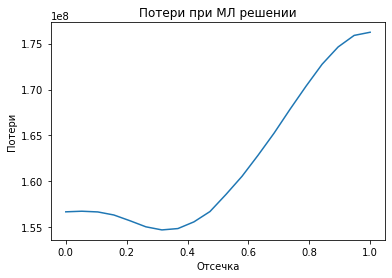

уровень порога по бизнес метрике 0.3157894736842105


In [25]:
busines_tr = business_threshold_calibrate(y_test,
                                          model_lr.predict_proba(X_test)[:, 1], 
                                          rubl_test=1400, 
                                          rubl_early_treatment=15000, 
                                          rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)